#### Classifying sex based on functional connectivity

This classifier pedicts the sex of an individual based on their functional connectivity. We are testing the effect on the classifier's prediction accuracy, z, based on amount of data, t, and number of subjects, n.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import (maskers, plotting)
from nilearn.connectome import ConnectivityMeasure
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore")

First we load demographic data. This includes our predicted variable (or class?) which is sex

In [2]:
demog_hcp = pd.read_csv('/home/jovyan/demographics-hcp100.csv')
y = demog_hcp.sex
demog_hcp.head(5) # show some of the data

,id,sex,[age,age],mean(age),Unnamed: 5,Unnamed: 6
0,100307,F,26,30,28.0,Q1,Q01
1,100408,M,31,35,33.0,Q3,Q03
2,101107,M,22,25,23.5,S500,Q06
3,101309,M,26,30,28.0,S500,Q06
4,101915,F,31,35,33.0,Q3,Q04


In [36]:
# the array timeseries contains timeseries for one single individual
# the array fcs contains the data for all 100 individuals
# y contains the sex labels for all 100 individuals
# groups contains this same information, but in a list instead of dataframe

subs = np.arange(1,101,1) # create a vector, 1 to 100, indicating the subject number
ind = 0 # initialize a count to index some variables inside the for loop
fcs = [] # initialize a list to append fc data to
women = [] # initialize a separate list to append fc data for women only
groups = []  # M or F, not sure why we need this yet

for sub in subs:
    func_data = pd.read_csv(f"/home/jovyan/shared/hcp_connectivity/schaefer100/sub{sub:03}_BOLD_timeseries_HCP.csv", header=None)
    timeseries = np.asarray(func_data) # turn dataframe into array
    timeseries = np.transpose(timeseries) # transpose so that columns are subjects
    fcs.append(timeseries) # append array to the list    
    if y[ind] == 'F':
        women.append(timeseries) # if subject is female, append their data to a list
    groups.append(y[ind])
    ind += 1
    
print(f'Data has {len(women)} women.')

Data has 54 women.


In [37]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(fcs)
print('Correlations of HCP subjects are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of HCP subjects are stacked in an array of shape (100, 100, 100)


In [38]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (100, 100).


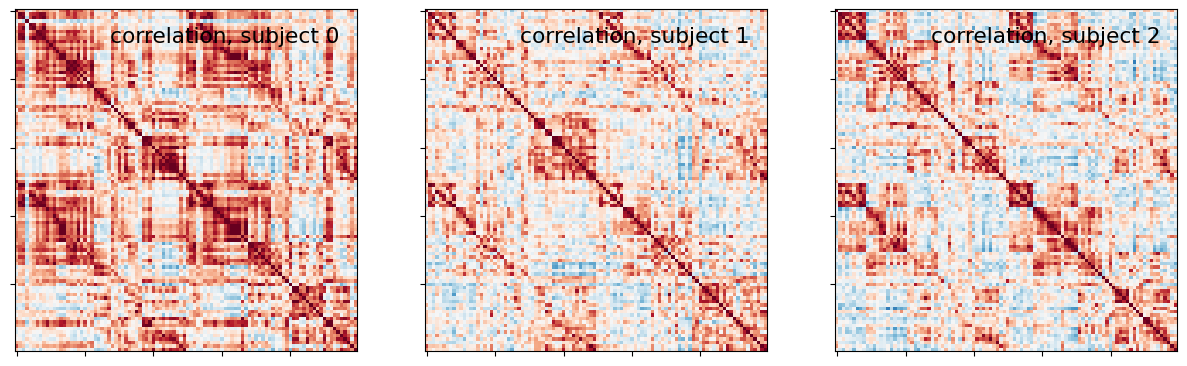

In [39]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, colorbar=False, axes=ax,
                         vmin=-0.8, vmax=0.8,
                         title='correlation, subject {}'.format(i))

In [114]:
trs = np.arange(205, 1190, 41)
numsubs = np.arange(40, 101, 20)
accuracies = []

In [115]:
#kinds = ['correlation', 'partial correlation', 'tangent']
_, classes_og = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=20)
pooled_subjects = np.asarray(fcs)
pooled_subjects.shape
#print(classes)

(100, 1189, 100)

In [46]:
# just testing some syntax
#n = 10
#arr = np.ones((len(pooled_subjects),), dtype=int)
#arr[:n] = 0
#np.random.shuffle(arr)
#this_sample = pooled_subjects[arr==1,:410,:]
#this_sample.shape

(90, 410, 100)

In [121]:
scores = {}
for t in trs:
    print(f"number of frames: {t}")
    for n in numsubs:
        print(f"number or subs: {n}")
        scores[t,n] = []
        arr = np.zeros(100)
        arr[:n] = 1
        np.random.shuffle(arr)
        this_sample = pooled_subjects[arr==1,:t,:]
        print(f"this sample is {this_sample.shape}")
        classes = classes_og[arr==1]
        cv = StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=int(n*.1))
        for train, test in cv.split(this_sample, classes):
            # *ConnectivityMeasure* can output the estimated subjects coefficients
            # as a 1D arrays through the parameter *vectorize*.
            connectivity = ConnectivityMeasure(kind='correlation', vectorize=True)
            # build vectorized connectomes for subjects in the train set
            connectomes = connectivity.fit_transform(this_sample[train])
            # fit the classifier
            classifier = LinearSVC().fit(connectomes, classes[train])
            # make predictions for the left-out test subjects
            predictions = classifier.predict(
                connectivity.transform(this_sample[test]))
            # store the accuracy for this cross-validation fold
            scores[t,n].append(accuracy_score(classes[test], predictions))

number of frames: 205
number or subs: 40
this sample is (40, 205, 100)
number or subs: 60
this sample is (60, 205, 100)
number or subs: 80
this sample is (80, 205, 100)
number or subs: 100
this sample is (100, 205, 100)
number of frames: 246
number or subs: 40
this sample is (40, 246, 100)
number or subs: 60
this sample is (60, 246, 100)
number or subs: 80
this sample is (80, 246, 100)
number or subs: 100
this sample is (100, 246, 100)
number of frames: 287
number or subs: 40
this sample is (40, 287, 100)
number or subs: 60
this sample is (60, 287, 100)
number or subs: 80
this sample is (80, 287, 100)
number or subs: 100
this sample is (100, 287, 100)
number of frames: 328
number or subs: 40
this sample is (40, 328, 100)
number or subs: 60
this sample is (60, 328, 100)
number or subs: 80
this sample is (80, 328, 100)
number or subs: 100
this sample is (100, 328, 100)
number of frames: 369
number or subs: 40
this sample is (40, 369, 100)
number or subs: 60
this sample is (60, 369, 100)


In [122]:
# Data for a three-dimensional scatter plot
xdata = []
ydata = []
zdata = []
for t in trs:
    for n in numsubs:
        xdata.append(t)
        ydata.append(n)
        #print(scores[t,n])
        zdata.append(np.mean(scores[t,n]))
        
#xdata_1 = pd.DataFrame(np.array(xdata).flatten())
#ydata_1 = pd.DataFrame(np.array(ydata).flatten())
#zdata_1 = pd.DataFrame(np.array(zdata).flatten())
#list(zdata)

[0.675,
 0.6833333333333333,
 0.6375,
 0.63,
 0.4,
 0.6666666666666667,
 0.6375,
 0.55,
 0.575,
 0.65,
 0.525,
 0.6,
 0.725,
 0.6833333333333333,
 0.6375,
 0.6,
 0.55,
 0.5,
 0.6625,
 0.5599999999999999,
 0.625,
 0.6166666666666667,
 0.5625,
 0.5399999999999999,
 0.6,
 0.4333333333333333,
 0.6125,
 0.48,
 0.5,
 0.55,
 0.6875,
 0.52,
 0.6,
 0.65,
 0.7,
 0.59,
 0.65,
 0.6,
 0.7375,
 0.6399999999999999,
 0.575,
 0.5833333333333333,
 0.7,
 0.65,
 0.725,
 0.7666666666666667,
 0.8,
 0.6799999999999999,
 0.7,
 0.65,
 0.7125,
 0.72,
 0.6,
 0.7999999999999999,
 0.725,
 0.69,
 0.525,
 0.5833333333333333,
 0.6375,
 0.6100000000000001,
 0.65,
 0.6833333333333333,
 0.6125,
 0.6499999999999999,
 0.575,
 0.7166666666666667,
 0.6375,
 0.63,
 0.625,
 0.6666666666666667,
 0.7,
 0.6300000000000001,
 0.8,
 0.5833333333333334,
 0.7,
 0.6000000000000001,
 0.425,
 0.6,
 0.625,
 0.6100000000000001,
 0.6,
 0.5166666666666666,
 0.5125,
 0.6,
 0.575,
 0.7500000000000001,
 0.6125,
 0.6100000000000001,
 0.525,
 0.

In [123]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plt

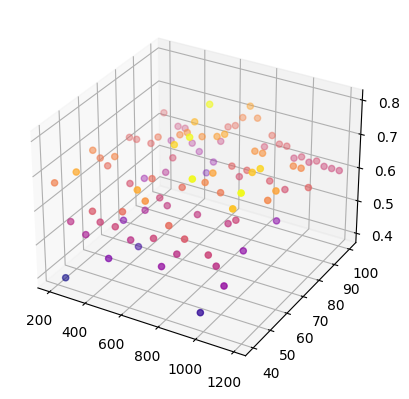

In [125]:
ax = plt.axes(projection='3d')
ax.scatter3D(xdata,ydata, zdata,c=zdata, cmap='plasma')

Everything below this is old code

In [ ]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.5, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

In [71]:
kinds = ['correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=15)
pooled_subjects = np.asarray(fcs)
#pooled_subjects.shape

In [74]:
scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

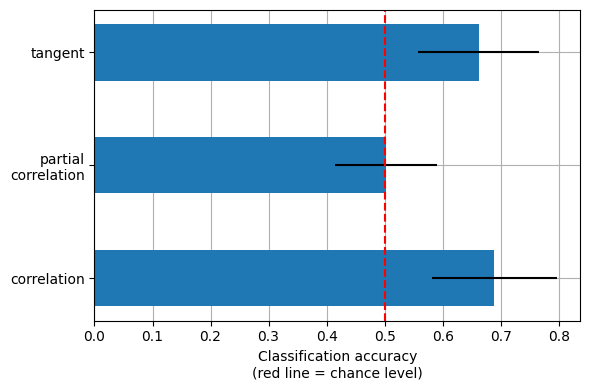

In [75]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.5, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

In [7]:
kinds = ['correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=25)
pooled_subjects = np.asarray(fcs)
#pooled_subjects.shape

In [8]:
scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

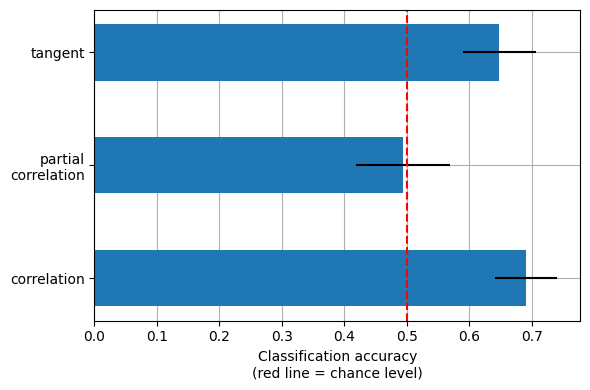

In [9]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.5, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

In [10]:
kinds = ['correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=25)
pooled_subjects = np.asarray(fcs)
#pooled_subjects.shape

In [11]:
scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

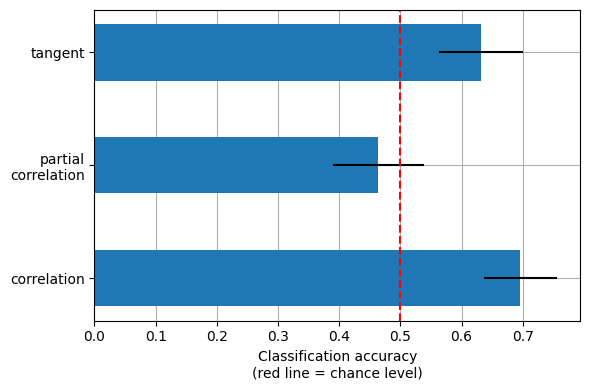

In [12]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.5, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

In [13]:
kinds = ['correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=25, random_state=0, test_size=5)
pooled_subjects = np.asarray(fcs)
#pooled_subjects.shape

In [14]:
scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

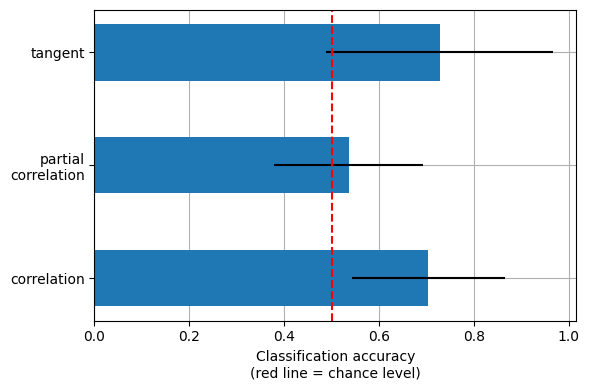

In [15]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.5, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()